Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

In [4]:
import os

# install fsl
!sudo apt-get remove -y --purge man-db
!apt-get update
!apt-get install neurodebian-archive-keyring
!add-apt-repository "deb http://neuro.debian.net/debian bionic main contrib non-free"
!apt-get install fsl-core

fslpath="/usr/share/fsl/5.0" 
os.environ["FSLOUTPUTTYPE"] = "NIFTI"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")
!. ${FSLDIR}/etc/fslconf/fsl.sh
!export FSLDIR PATH

os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'man-db' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: line 1: add-apt-repository: command not found
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: line 1: /usr/share/fsl/5.0/etc/fslconf/fsl.sh: No such file or directory


KeyError: 'LD_LIBRARY_PATH'

In [ ]:
# add mni template to fsl dir
!mkdir /usr/share/fsl/5.0/data/standard
!gdown --id 1lytUR8CJkcvGIdhndoLjKCUloKl80iCG 
!unzip /content/mniatlas.zip -d /usr/share/fsl/5.0/data/standard  

## Imports

In [3]:
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

## Download data and MNI atlas

In [2]:
# !gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
# !unzip ./ds000102.zip -d ./data

# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O ~/Downloads/mniatlas.zip
# !unzip -oq ~/Downloads/mniatlas.zip -d ${FSLDIR}/data/standard

## Experiment parameters

In [51]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "workingdir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


fslpath = "/usr/local/fsl"
os.environ["FSLOUTPUTTYPE"] = "NIFTI"
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

## Specify Nodes for the main workflow¶

In [52]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")

# MCFLIRT - motion correction
mcflirt = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="mcflirt"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration Workflow¶

In [53]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5, robust=True, output_type="NIFTI_GZ"), name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type="NIFTI_GZ"), name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]


# Threshold - Threshold WM probability image
threshold = Node(
    Threshold(thresh=0.5, args="-bin", output_type="NIFTI_GZ"), name="threshold"
)

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(
    FLIRT(
        dof=6,
        cost="bbr",
        schedule=opj(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
        output_type="NIFTI_GZ",
    ),
    name="coreg_bbr",
)

# Apply coregistration warp to functional images
applywarp = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI"), name="applywarp"
)

# Apply coregistration warp to mean file
applywarp_mean = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI_GZ"),
    name="applywarp_mean",
)

# Create a coregistration workflow
coregwf = Workflow(name="coregwf")
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect(
    [
        (bet_anat, segmentation, [("out_file", "in_files")]),
        (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
        (bet_anat, coreg_pre, [("out_file", "reference")]),
        (threshold, coreg_bbr, [("out_file", "wm_seg")]),
        (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
        (coreg_bbr, applywarp, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp, [("out_file", "reference")]),
        (coreg_bbr, applywarp_mean, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp_mean, [("out_file", "reference")]),
    ]
)

## Specify input & output stream¶

In [65]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow¶

In [66]:
# Create a preprocessing workflow
preproc = Workflow(name="preproc")
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, mcflirt, [("roi_file", "in_file")]),
        (mcflirt, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coregwf,
            [("anat", "bet_anat.in_file"), ("anat", "coreg_bbr.reference")],
        ),
        (
            mcflirt,
            coregwf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
                ("mean_img", "applywarp_mean.in_file"),
            ],
        ),
        (slicetimer, coregwf, [("slice_time_corrected_file", "applywarp.in_file")]),
        (coregwf, smooth, [("applywarp.out_file", "in_files")]),
        (mcflirt, datasink, [("par_file", "preproc.@par")]),
        (smooth, datasink, [("smoothed_files", "preproc.@smooth")]),
        (coregwf, datasink, [("applywarp_mean.out_file", "preproc.@mean")]),
        (coregwf, art, [("applywarp.out_file", "realigned_files")]),
        (mcflirt, art, [("par_file", "realignment_parameters")]),
        (
            coregwf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc.@mat_file"),
                ("bet_anat.out_file", "preproc.@brain"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc.@outlier_files"),
                ("plot_files", "preproc.@plot_files"),
            ],
        ),
    ]
)

## Visualize the workflow¶

221203-23:43:48,898 nipype.workflow INFO:
	 Generated workflow graph: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


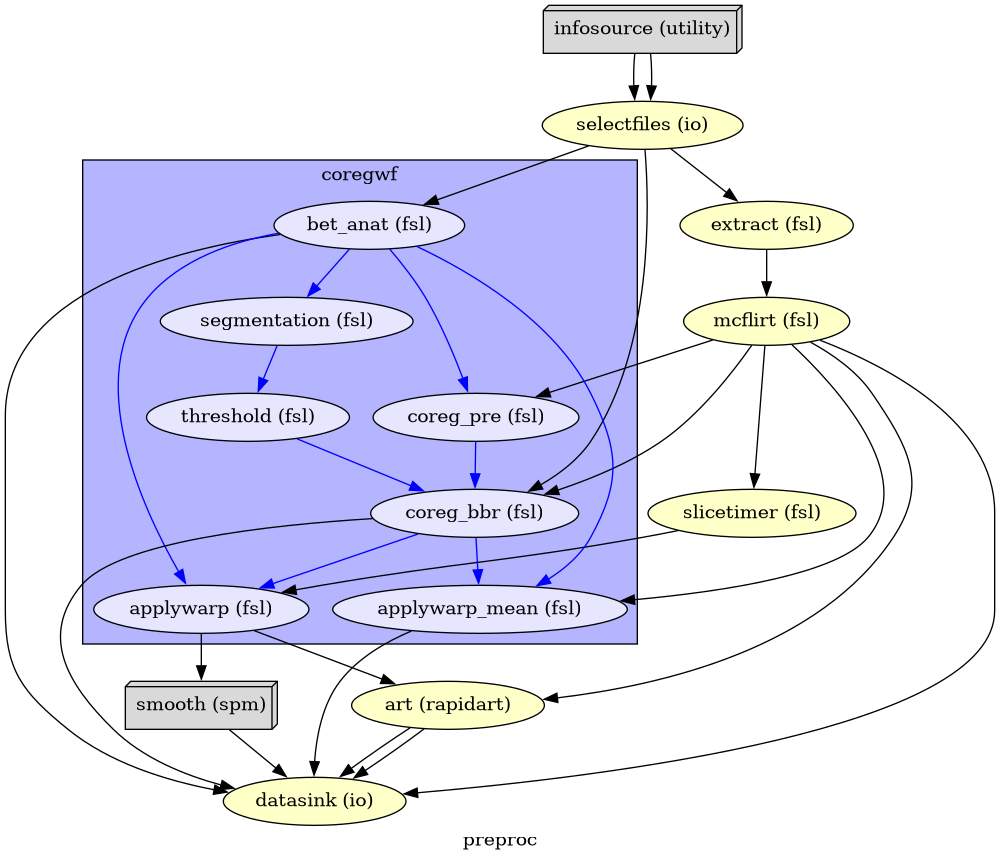

In [67]:
# Create preproc output graph
preproc.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc.base_dir, "preproc", "graph.png"))

221203-23:43:49,522 nipype.workflow INFO:
	 Generated workflow graph: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


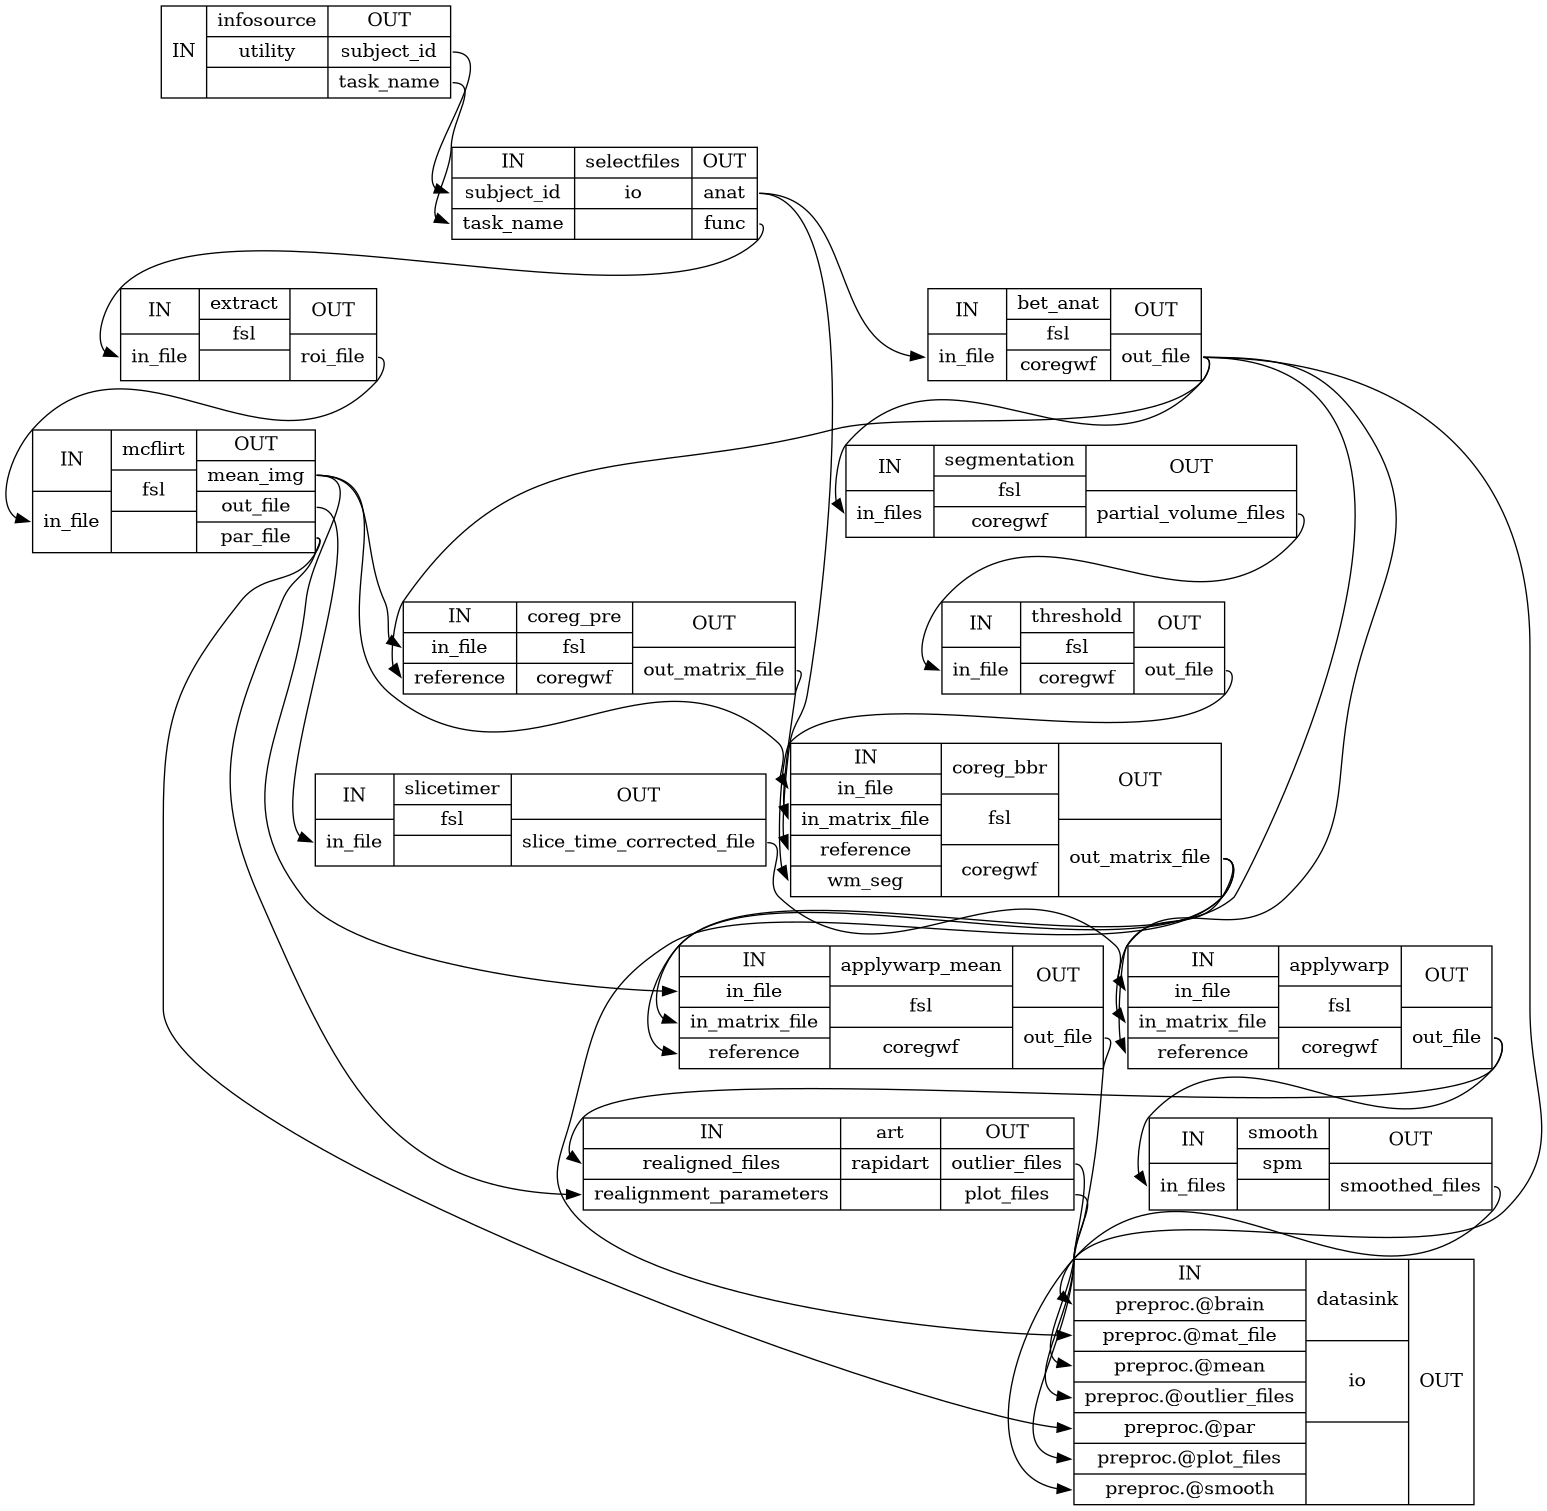

In [68]:
# Visualize the detailed graph
preproc.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc.base_dir, "preproc", "graph_detailed.png"))

## Run the Workflow¶

In [72]:
from nipype.interfaces.fsl import Info

Info

nipype.interfaces.fsl.base.Info

In [99]:
!fsl --help

You need to source an FSL setup file - either fsl.sh or fsl.csh in $FSLDIR/etc/fslconf !


In [78]:
iii.version()

In [69]:
preproc.run('MultiProc', plugin_args={'n_procs': 8})

221203-23:43:49,713 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


221203-23:43:49,737 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221203-23:43:49,742 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221203-23:43:49,848 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc.selectfiles" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/selectfiles".


221203-23:43:49,878 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221203-23:43:49,884 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001872s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001872s.


221203-23:43:51,745 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc.selectfiles).


221203-23:43:51,819 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221203-23:43:51,930 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.bet_anat" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/bet_anat".


INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.bet_anat" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/bet_anat".


221203-23:43:51,944 nipype.workflow INFO:
	 [Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


221203-23:43:51,929 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/extract".


INFO:nipype.workflow:[Node] Setting-up "preproc.extract" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/extract".


221203-23:43:51,954 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


221203-23:43:53,337 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 1.378097s.


INFO:nipype.workflow:[Node] Finished "extract", elapsed time 1.378097s.


221203-23:43:53,744 nipype.workflow INFO:
	 [Job 1] Completed (preproc.extract).


INFO:nipype.workflow:[Job 1] Completed (preproc.extract).


221203-23:43:53,747 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coregwf.bet_anat


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coregwf.bet_anat


221203-23:43:53,803 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt".


INFO:nipype.workflow:[Node] Setting-up "preproc.mcflirt" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt".


221203-23:43:53,813 nipype.workflow INFO:
	 [Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>


INFO:nipype.workflow:[Node] Executing "mcflirt" <nipype.interfaces.fsl.preprocess.MCFLIRT>


221203-23:43:55,746 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.coregwf.bet_anat


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.coregwf.bet_anat


221203-23:43:58,124 nipype.workflow INFO:
	 [Node] Finished "bet_anat", elapsed time 6.175108s.


INFO:nipype.workflow:[Node] Finished "bet_anat", elapsed time 6.175108s.


221203-23:43:59,749 nipype.workflow INFO:
	 [Job 2] Completed (preproc.coregwf.bet_anat).


INFO:nipype.workflow:[Job 2] Completed (preproc.coregwf.bet_anat).


221203-23:43:59,752 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.mcflirt


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.mcflirt


221203-23:43:59,802 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.segmentation" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/segmentation".


INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.segmentation" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/segmentation".


221203-23:43:59,812 nipype.workflow INFO:
	 [Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


INFO:nipype.workflow:[Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


221203-23:44:01,752 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt


221203-23:44:43,523 nipype.workflow INFO:
	 [Node] Finished "mcflirt", elapsed time 49.705344s.


INFO:nipype.workflow:[Node] Finished "mcflirt", elapsed time 49.705344s.


221203-23:44:43,525 nipype.workflow WARNING:
	 Storing result file without outputs


221203-23:44:43,528 nipype.workflow WARNING:
	 [Node] Error on "preproc.mcflirt" (/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt)


221203-23:44:43,788 nipype.workflow ERROR:
	 Node mcflirt.b0 failed to run on host mink.


ERROR:nipype.workflow:Node mcflirt.b0 failed to run on host mink.


221203-23:44:43,790 nipype.workflow ERROR:
	 Saving crash info to /home/user/data/psy_misc/tewa2-neuroimaging/assignments/crash-20221203-234443-user-mcflirt.b0-71fffc15-8c3e-4d6c-b608-7f8761da4d79.pklz
Traceback (most recent call last):
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while exec

ERROR:nipype.workflow:Saving crash info to /home/user/data/psy_misc/tewa2-neuroimaging/assignments/crash-20221203-234443-user-mcflirt.b0-71fffc15-8c3e-4d6c-b608-7f8761da4d79.pklz
Traceback (most recent call last):
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node mcflirt.

Cm

221203-23:44:43,794 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coregwf.segmentation


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coregwf.segmentation


221203-23:47:52,524 nipype.workflow INFO:
	 [Node] Finished "segmentation", elapsed time 232.708252s.


INFO:nipype.workflow:[Node] Finished "segmentation", elapsed time 232.708252s.


221203-23:47:53,964 nipype.workflow INFO:
	 [Job 4] Completed (preproc.coregwf.segmentation).


INFO:nipype.workflow:[Job 4] Completed (preproc.coregwf.segmentation).


221203-23:47:53,973 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221203-23:47:54,38 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.threshold" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/threshold".


INFO:nipype.workflow:[Node] Setting-up "preproc.coregwf.threshold" in "/home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/coregwf/_subject_id_02_task_name_flanker/threshold".


221203-23:47:54,50 nipype.workflow INFO:
	 [Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


INFO:nipype.workflow:[Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


221203-23:47:54,752 nipype.workflow INFO:
	 [Node] Finished "threshold", elapsed time 0.695856s.


INFO:nipype.workflow:[Node] Finished "threshold", elapsed time 0.695856s.


221203-23:47:55,965 nipype.workflow INFO:
	 [Job 7] Completed (preproc.coregwf.threshold).


INFO:nipype.workflow:[Job 7] Completed (preproc.coregwf.threshold).


221203-23:47:55,973 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221203-23:47:57,965 nipype.workflow INFO:
	 ***********************************


INFO:nipype.workflow:***********************************


221203-23:47:57,969 nipype.workflow ERROR:
	 could not run node: preproc.mcflirt.b0


ERROR:nipype.workflow:could not run node: preproc.mcflirt.b0


221203-23:47:57,973 nipype.workflow INFO:
	 crashfile: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/crash-20221203-234443-user-mcflirt.b0-71fffc15-8c3e-4d6c-b608-7f8761da4d79.pklz


INFO:nipype.workflow:crashfile: /home/user/data/psy_misc/tewa2-neuroimaging/assignments/crash-20221203-234443-user-mcflirt.b0-71fffc15-8c3e-4d6c-b608-7f8761da4d79.pklz


221203-23:47:57,975 nipype.workflow INFO:
	 ***********************************


INFO:nipype.workflow:***********************************


RuntimeError: Traceback (most recent call last):
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node mcflirt.

Cmdline:
	mcflirt -in /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/extract/sub-02_task-flanker_run-1_bold_roi.nii -meanvol -out /home/user/data/psy_misc/tewa2-neuroimaging/assignments/output/workingdir/preproc/_subject_id_02_task_name_flanker/mcflirt/sub-02_task-flanker_run-1_bold_roi_mcf.nii -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/interfaces/base/core.py", line 401, in run
	    outputs = self.aggregate_outputs(runtime)
	  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/interfaces/base/core.py", line 430, in aggregate_outputs
	    predicted_outputs = self._list_outputs()  # Predictions from _list_outputs
	  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/nipype/interfaces/fsl/preprocess.py", line 936, in _list_outputs
	    if LooseVersion(Info.version()) < LooseVersion("6.0.0"):
	  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/looseversion.py", line 135, in __lt__
	    c = self._cmp(other)
	  File "/home/user/miniconda3/envs/fmri37/lib/python3.7/site-packages/looseversion.py", line 183, in _cmp
	    if self.version == other.version:
	AttributeError: 'LooseVersion' object has no attribute 'version'

